## 1. Khai báo thư viện và đọc dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
hotel_booking = pd.read_csv("data/hotel_bookings.csv")
hotel_booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
hotel_booking.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [4]:
hotel_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
hotel_booking.shape

(119390, 32)

**Thuộc tính**
- **hotel**: biến target, 
- **is_canceled**: trạng thái đặt phòng có bị huỷ, 1 là đã huỷ, 0 là chưa huỷ (*categorical*).
- **lead_time**: Số ngày trôi qua kể từ ngày nhập đặt phòng vào PMS và ngày đến.
- **arrival_date_week_number**: 
- **is_repeated_guest**: một khách có đặt nhiều lần.
- **previous_cancellations**: số lần đặt trước bị huỷ trước lần đặt hiện tại của khách hàng.
- **previous_bookings_not_canceled**: số lần đặt trước không bị huỷ trước lần đặt hiện tại của khách hàng.
- **reservation_status**: trạng thái đặt phòng cuối cùng (Canceled: đã huỷ, Check-Out: khách hàng đã checkin nhưng đã rời đi, No-Show: đặt nhưng ko nhận phòng)
- **reservation_status_date**: Ngày mà trạng thái cuối cùng được thiết lập. Biến này có thể được sử dụng cùng với *Reservation_Status* để hiểu khi nào đặt phòng bị hủy hoặc khi nào khách hàng trả phòng khách sạn.
- **market_segment**: Phân khúc thị trường. “TA”: Đại lý Du lịch, “TO”: Nhà điều hành Tour.
- **adults**: Số lượng người lớn.
- **babies**: Số lượng trẻ sơ sinh.
- **children**: Số lượng trẻ em.
- **distribution_channel**: Kênh phân phối đặt phòng ( 

## 2. Khám phá và xử lý dữ liệu

#### Xoá các quan sát trùng lặp (nếu có)

In [6]:
hotel_booking = hotel_booking.drop_duplicates()
hotel_booking.shape

(87396, 32)

#### Xoá các quan sát không có ý nghĩa

In [7]:
# Vì cả 3 biến adults, babies and children không thể đồng thời bằng 0 được 
# nên ta loại những quan sát có cả 3 biến đồng thời bằng 0
filtr = (hotel_booking['children'] == 0) & (hotel_booking['adults'] == 0) & (hotel_booking['babies'] == 0)
hotel_booking = hotel_booking[~filtr]
hotel_booking.shape

(87230, 32)

#### Quan sát dữ liệu *'na'*

In [8]:
hotel_booking.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             447
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             12141
company                           81993


#### **Xoá cột 'company' và 'agent' vì số giá trị 'nan' quá lớn** 

In [9]:
hotel_booking = hotel_booking.drop(columns=["company", "agent"])
hotel_booking.shape

(87230, 30)

#### Điền các quan sát có giá trị 'na' ở cột *'children'* và *'country'*

In [10]:
hotel_booking = hotel_booking.apply(lambda x: x.fillna(x.value_counts().index[0]))
hotel_booking.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

#### Các cột có kiểu dữ liệu categorical

In [11]:
hotel_booking_cp = hotel_booking.copy()

In [12]:
# danh sách các thuộc tính categorical
categorical_features = ['hotel', 'arrival_date_year', 'arrival_date_month', 'stays_in_weekend_nights',
                        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'arrival_date_week_number',
                        'arrival_date_day_of_month', 'market_segment', 'distribution_channel', 'is_repeated_guest',
                        'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type',
                        'assigned_room_type', 'booking_changes','deposit_type', 'days_in_waiting_list','customer_type',
                        'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status']
hotel_booking_cp[categorical_features] = hotel_booking_cp[categorical_features].astype('category')

print('numbers category:',len(categorical_features))

numbers category: 26


#### Các cột có kiểu dữ liệu numeric

In [13]:
# Danh sách các thuộc tính numeric
numerical_features = ['lead_time', 'adr']
print('numbers numeric: ', len(numerical_features))

numbers numeric:  2


#### Quan sát giá trị của các cột có kiểu dữ liệu categotical

In [14]:
for col in categorical_features:
    print(f"{col}: \n{hotel_booking_cp[col].unique()}\n")

hotel: 
['Resort Hotel', 'City Hotel']
Categories (2, object): ['City Hotel', 'Resort Hotel']

arrival_date_year: 
[2015, 2016, 2017]
Categories (3, int64): [2015, 2016, 2017]

arrival_date_month: 
['July', 'August', 'September', 'October', 'November', ..., 'February', 'March', 'April', 'May', 'June']
Length: 12
Categories (12, object): ['April', 'August', 'December', 'February', ..., 'May', 'November', 'October', 'September']

stays_in_weekend_nights: 
[0, 1, 2, 4, 3, ..., 16, 18, 19, 10, 14]
Length: 17
Categories (17, int64): [0, 1, 2, 3, ..., 14, 16, 18, 19]

stays_in_week_nights: 
[0, 1, 2, 3, 4, ..., 17, 32, 26, 18, 34]
Length: 33
Categories (33, int64): [0, 1, 2, 3, ..., 34, 40, 42, 50]

adults: 
[2, 1, 3, 4, 40, ..., 20, 6, 5, 10, 0]
Length: 14
Categories (14, int64): [0, 1, 2, 3, ..., 27, 40, 50, 55]

children: 
[0.0, 1.0, 2.0, 10.0, 3.0]
Categories (5, float64): [0.0, 1.0, 2.0, 3.0, 10.0]

babies: 
[0, 1, 2, 10, 9]
Categories (5, int64): [0, 1, 2, 9, 10]

meal: 
['BB', 'FB', '

In [15]:
hotel_booking_cp.describe(include=['category'])

,hotel,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status
count,87230,87230,87230,87230,87230,87230,87230,87230,87230.0,87230,...,87230,87230,87230,87230,87230,87230,87230,87230,87230,87230
unique,2,3,12,53,31,17,33,14,5.0,5,...,73,9,11,19,3,127,4,5,6,3
top,City Hotel,2016,August,33,17,0,1,2,0.0,0,...,0,A,A,0,No Deposit,0,Transient,0,0,Check-Out
freq,53274,42313,11242,2789,3015,35058,22173,64497,78866.0,86316,...,83692,56436,46283,71425,86085,86375,71862,79924,43789,63221


In [46]:
hotel_booking_cp.describe()

,is_canceled,lead_time,adr
count,87230.000000,87230.000000,87230.000000
mean,0.275238,79.971019,106.518031
std,0.446637,86.058683,54.891227
min,0.000000,0.000000,-6.380000
25%,0.000000,11.000000,72.250000
50%,0.000000,49.000000,98.200000
75%,1.000000,125.000000,134.100000
max,1.000000,737.000000,5400.000000


## 3. Trực quan hoá dữ liệu

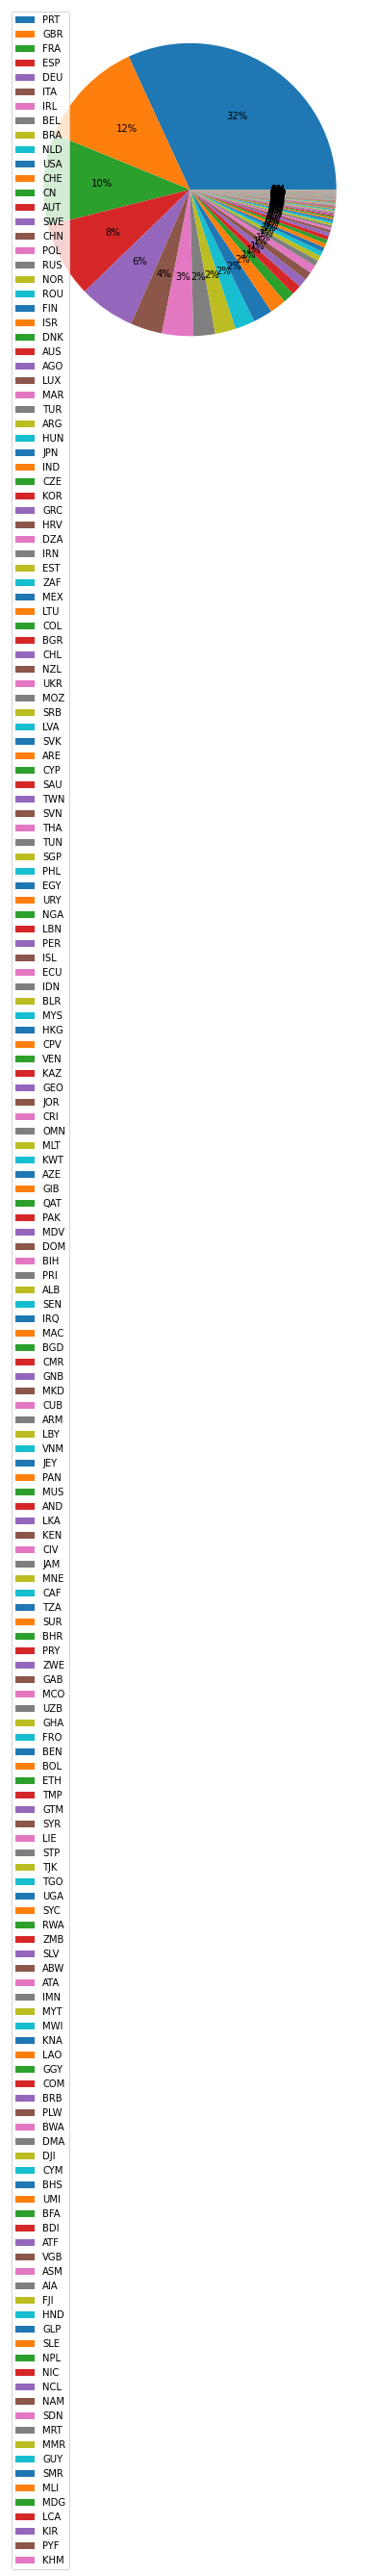

In [18]:
country = hotel_booking_cp['country'].value_counts().index
fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(hotel_booking_cp['country'].value_counts()
       , autopct='%.0f%%')
legend = ax.legend(country, loc='best')

d = {"down" : 30, "up" : -30}

def func(evt):
    if legend.contains(evt):
        bbox = legend.get_bbox_to_anchor()
        bbox = Bbox.from_bounds(bbox.x0, bbox.y0+d[evt.button], bbox.width, bbox.height)
        tr = legend.axes.transAxes.inverted()
        legend.set_bbox_to_anchor(bbox.transformed(tr))
        fig.canvas.draw_idle()
fig.canvas.mpl_connect("scroll_event", func)

plt.show()

#### Quan sát phân phối của các cột có kiểu dữ liệu numerical

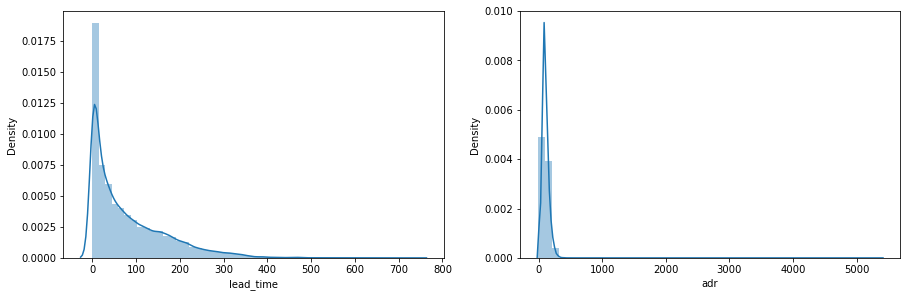

In [19]:
# Sử dụng đồ thị quan sát phân phối của các thuộc tính numeric
plt.figure(figsize=(15,10), facecolor='white')
plotnumber = 1
for numerical_feature in numerical_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.distplot(hotel_booking_cp[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

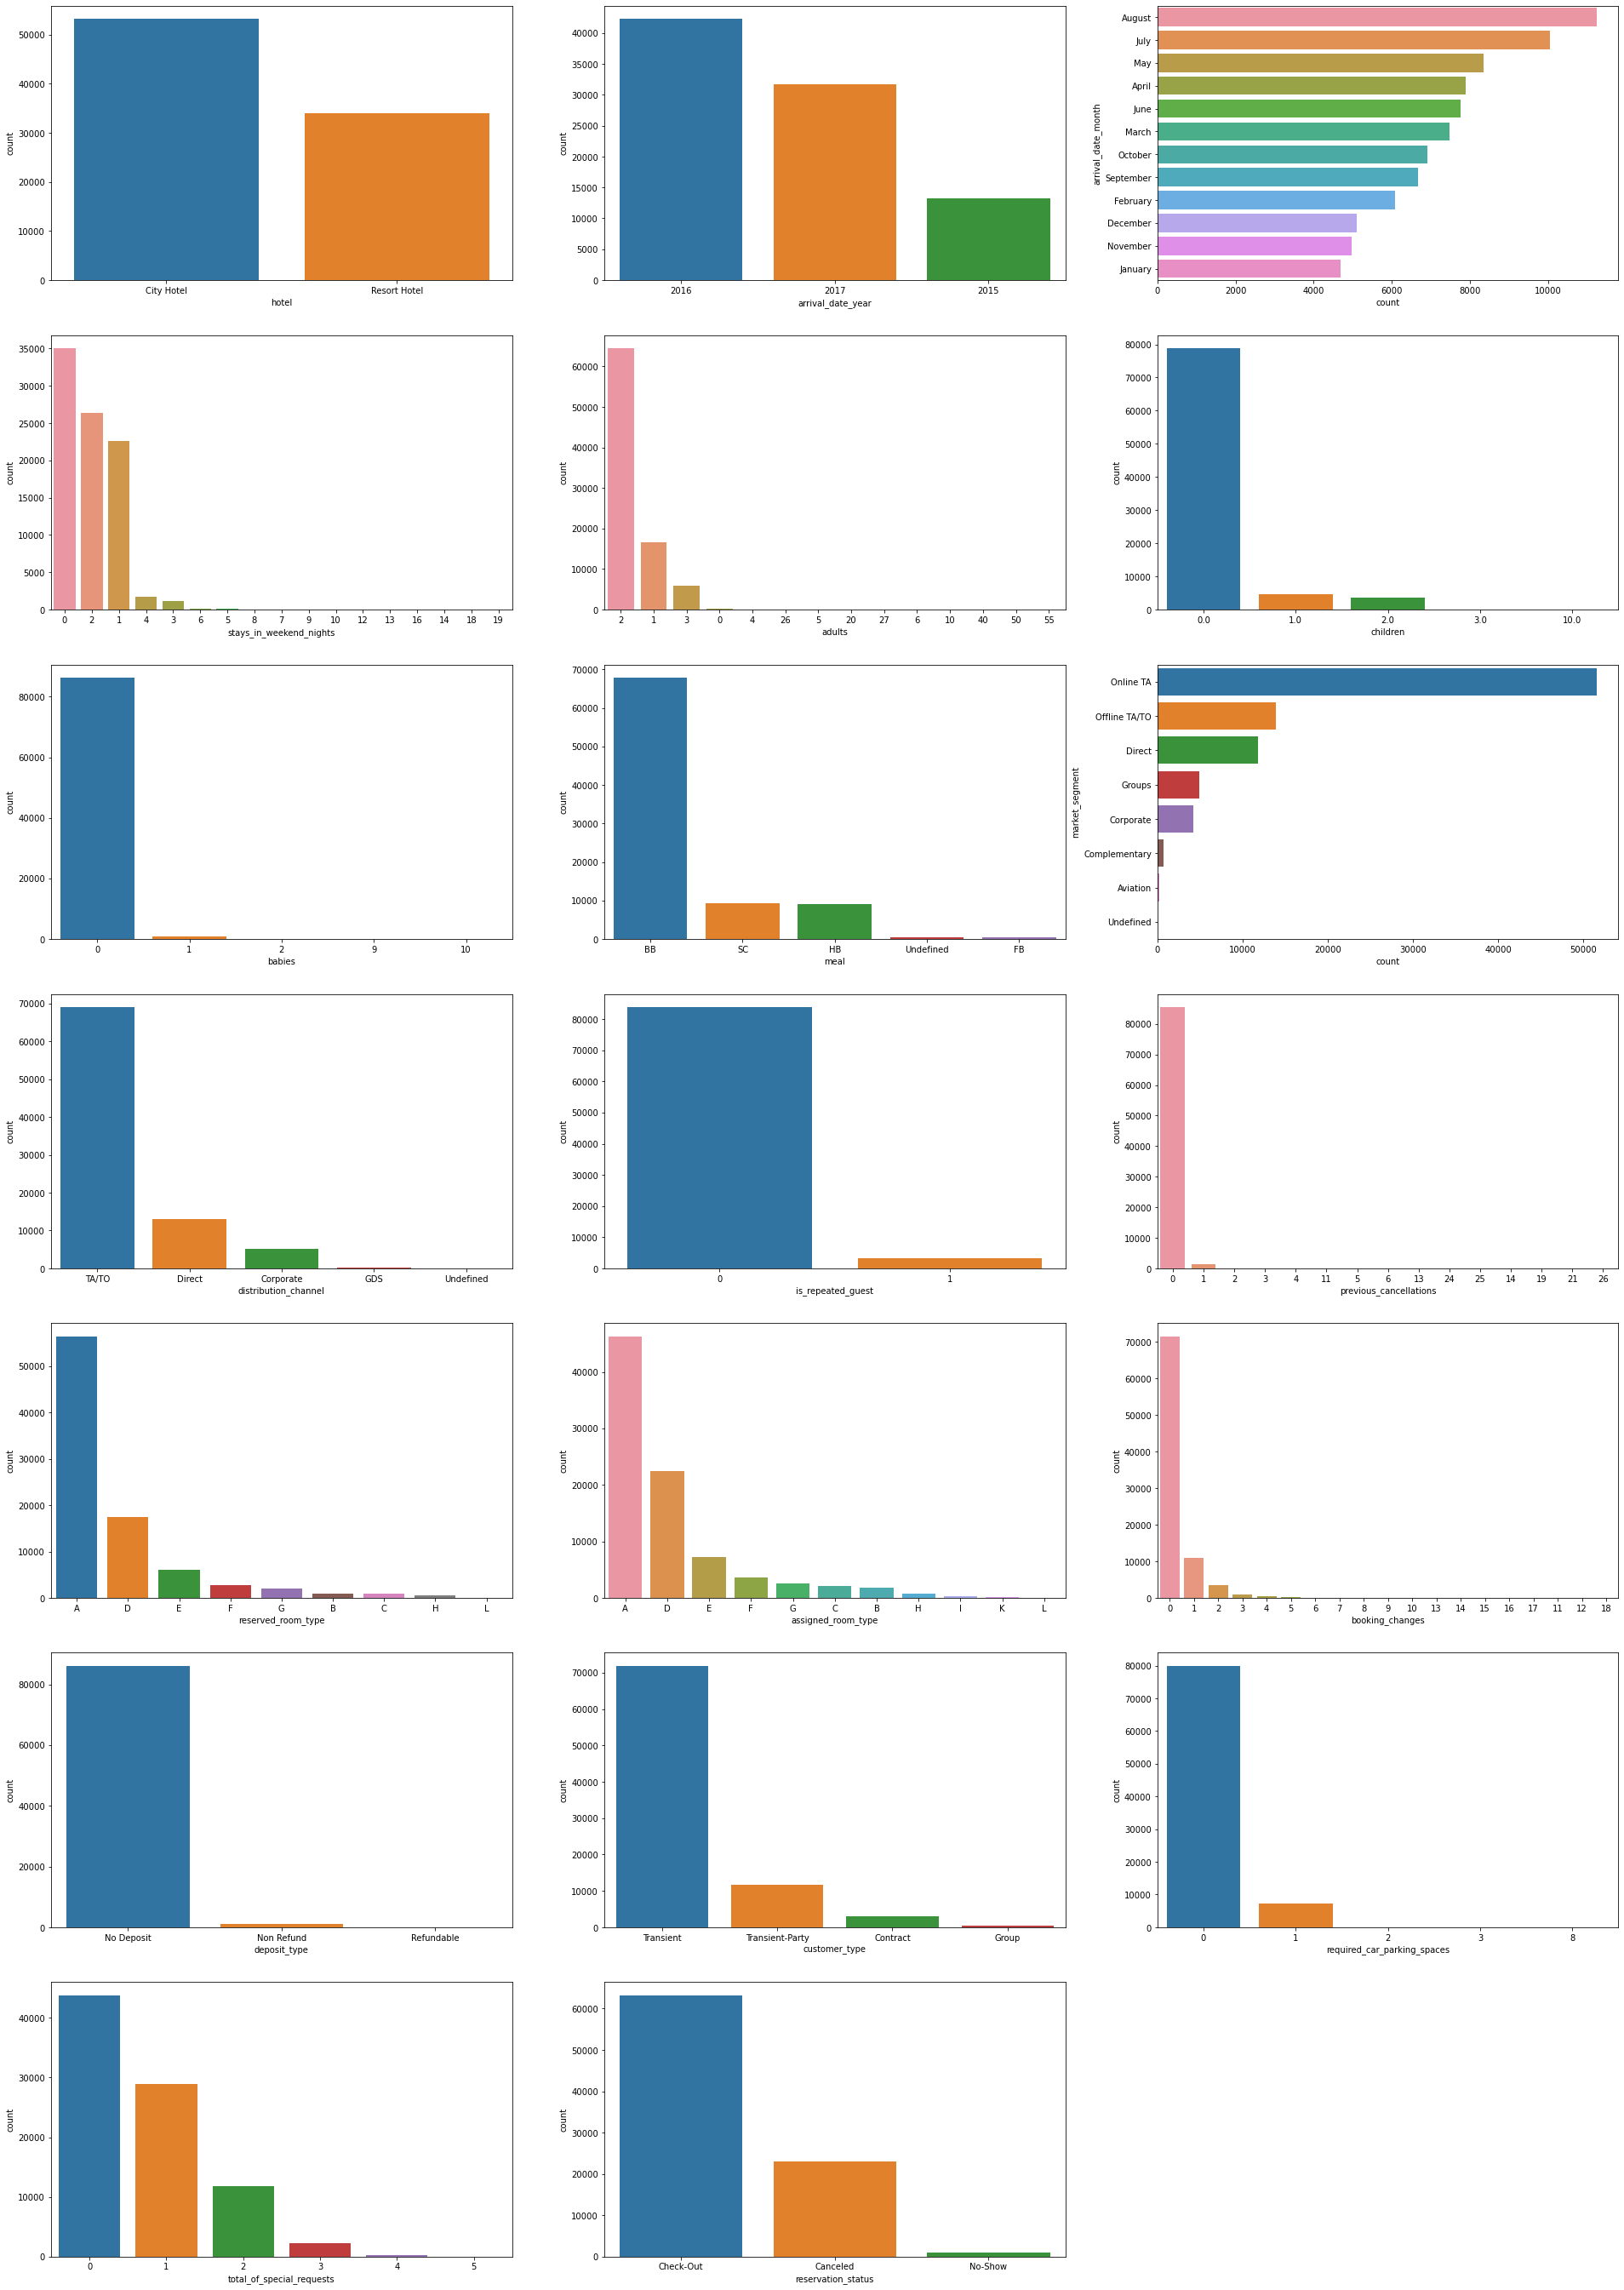

In [20]:
# Số lượng phân loại cụ thể của các thuộc tính categorical  
plt.figure(figsize=(33,70), facecolor='white')
plotnumber = 1 
for categorical_feature in categorical_features:
    ax = plt.subplot(10,3, plotnumber)
    if len(hotel_booking_cp[categorical_feature].unique()) <= 30:
        if categorical_feature == 'arrival_date_month' or categorical_feature == 'market_segment':
            sns.countplot(y=categorical_feature
                          , data=hotel_booking_cp
                          , order=hotel_booking_cp[categorical_feature].value_counts().index)
            plt.ylabel(categorical_feature)

        else:
            sns.countplot(x=categorical_feature
                          , data=hotel_booking_cp
                          , order=hotel_booking_cp[categorical_feature].value_counts().index)
            plt.xlabel(categorical_feature)
        plotnumber += 1
plt.show()

In [21]:
(hotel_booking_cp['deposit_type'].value_counts()/len(hotel_booking_cp))*100

No Deposit    98.687378
Non Refund     1.189958
Refundable     0.122664
Name: deposit_type, dtype: float64

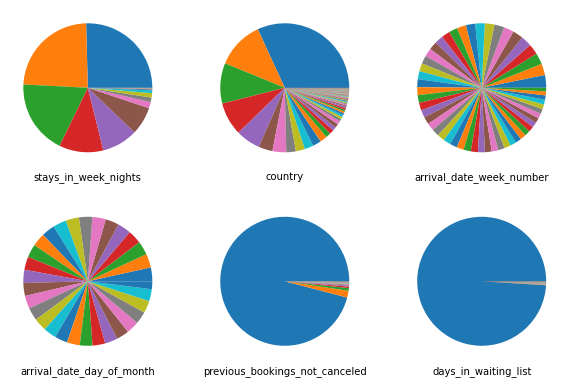

In [22]:
# Số lượng phân loại cụ thể của các thuộc tính categorical
plt.figure(figsize=(10,35), facecolor='white')
plotnumber = 1 
for categorical_feature in categorical_features:
    if len(hotel_booking_cp[categorical_feature].unique()) > 30:
        ax = plt.subplot(10,3, plotnumber)
        plt.pie(x=hotel_booking_cp[categorical_feature].value_counts(), data=hotel_booking)
        plt.xlabel(categorical_feature)
        plotnumber += 1
plt.show()

**Nhận xét:** Các cột *'babies', 'is_repeated_guest', 'previous_cancellations', 'deposit_type', 'previous_booking_not_canceled', 'days_in_waiting_list'* có sự thiên lệch khá lớn về số lượng quan sát ở một giá trị phân loại so với các giá trị phân loại còn lại. 

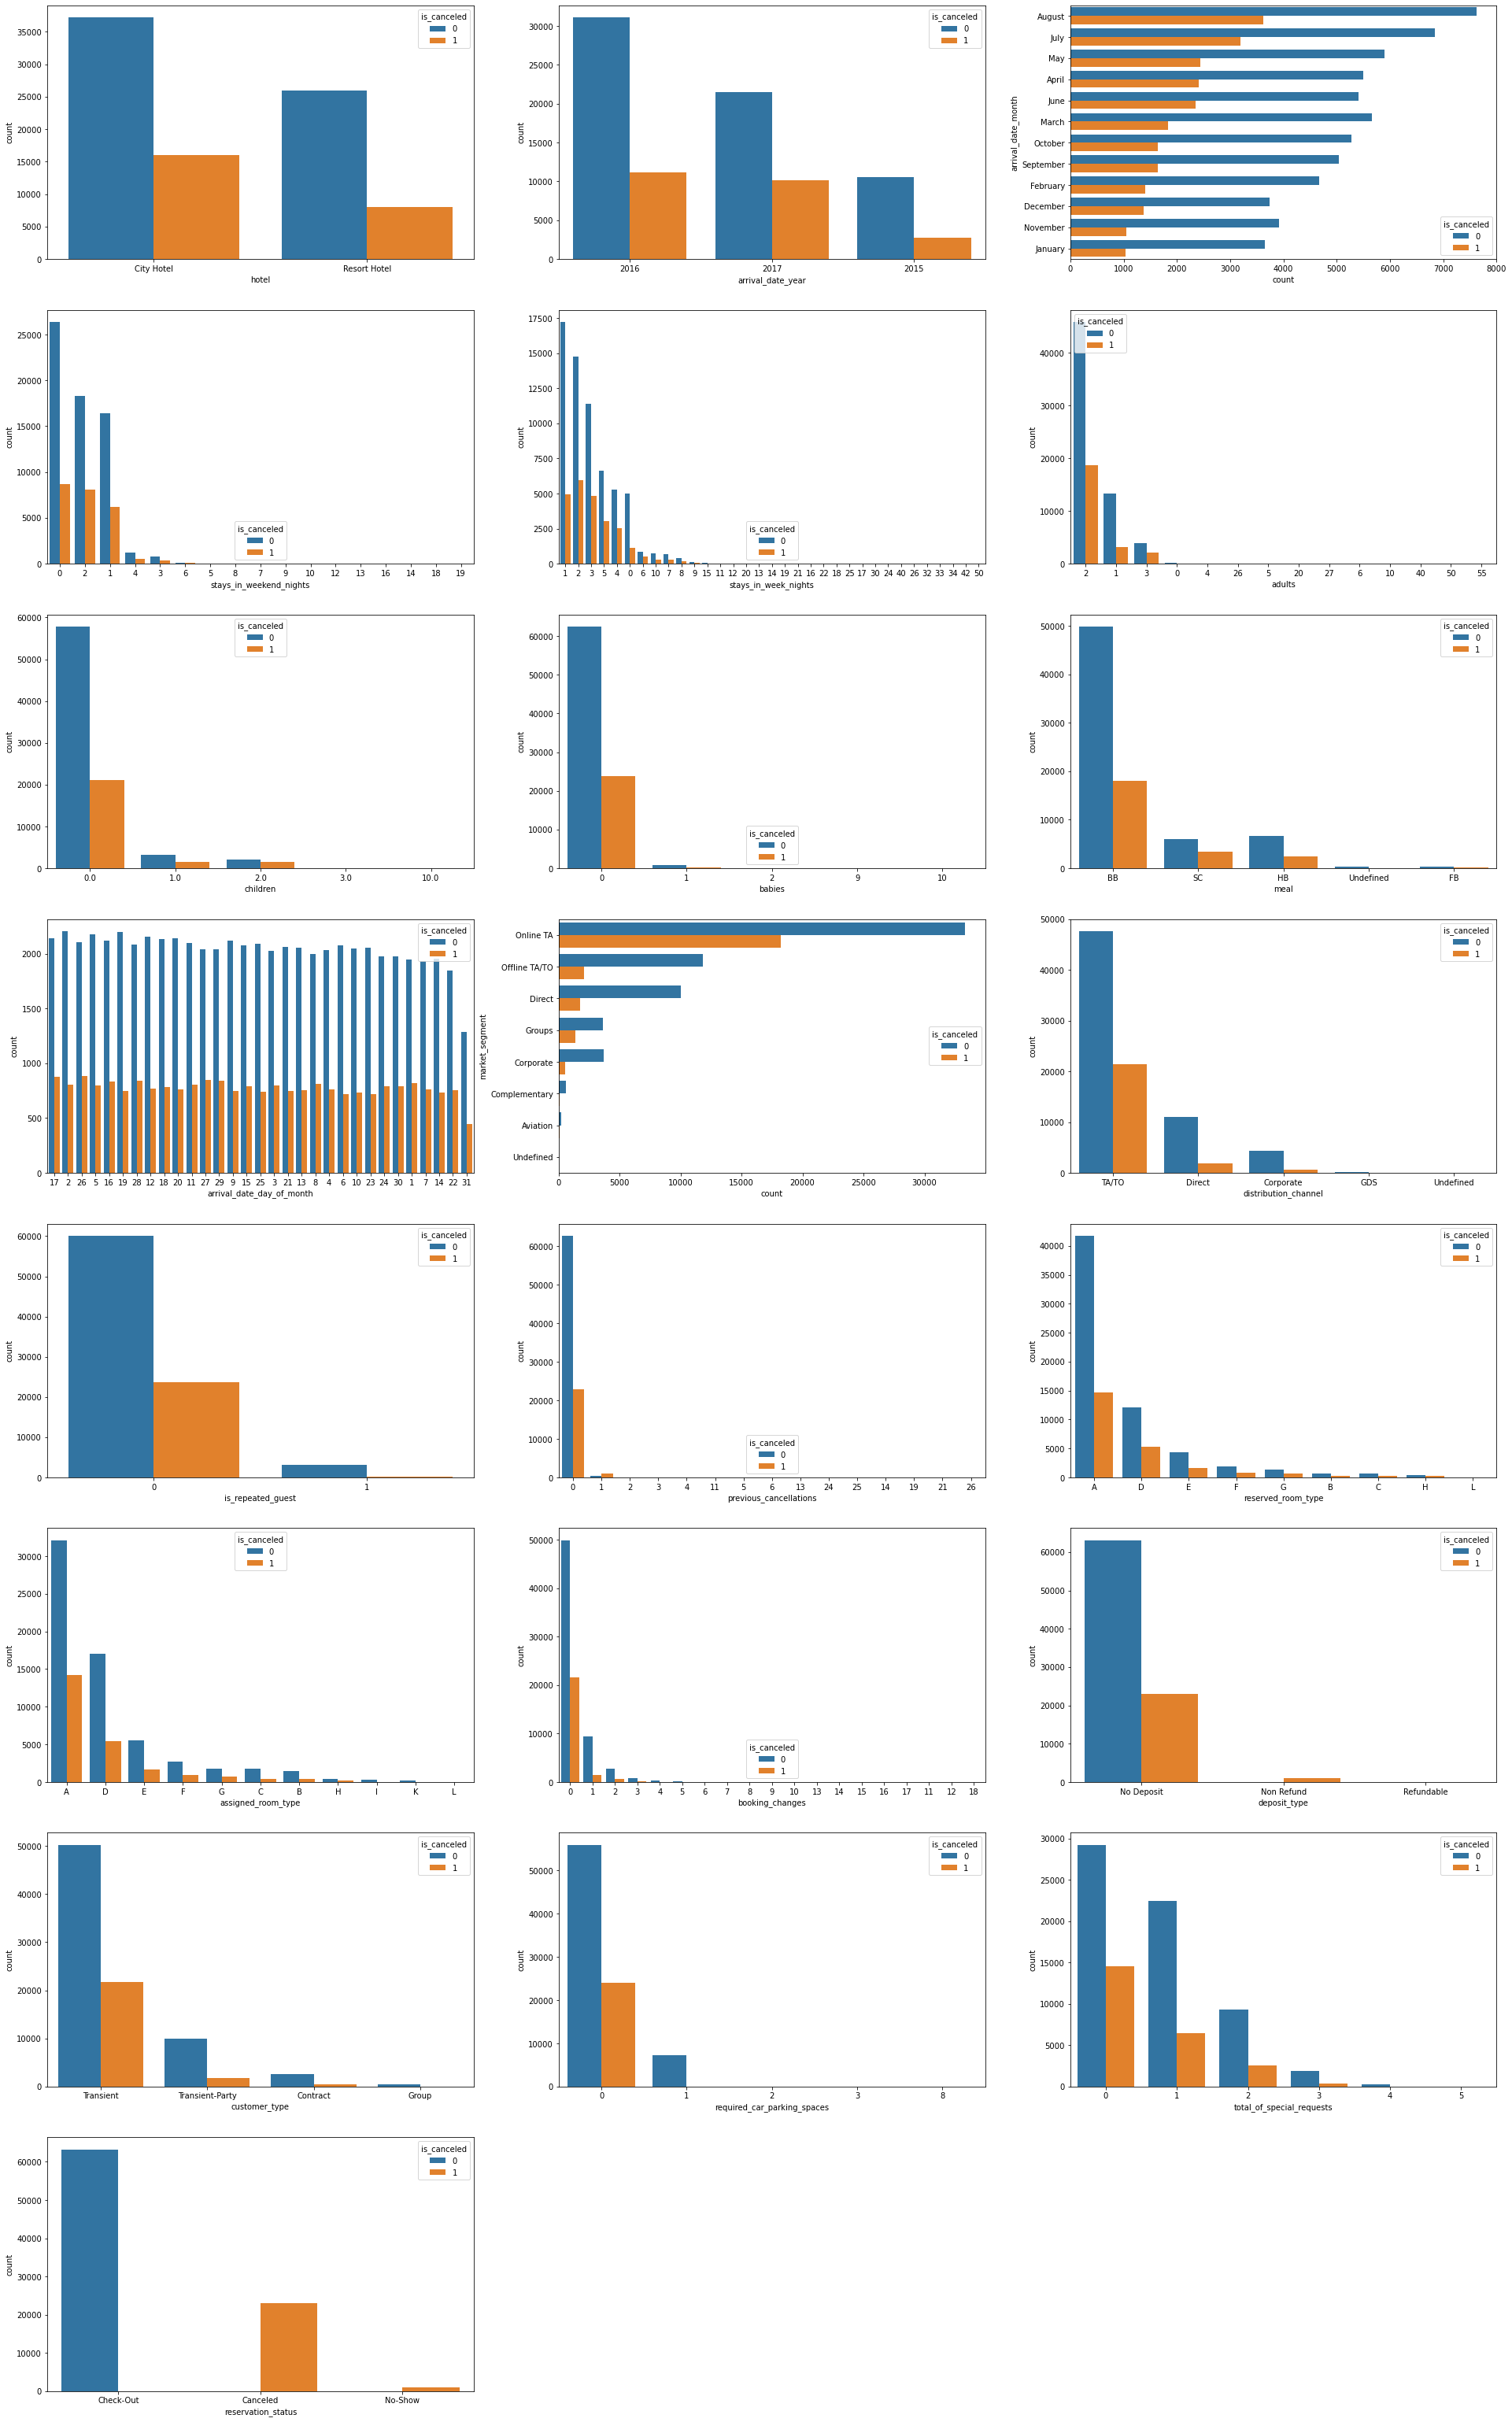

In [23]:
plt.figure(figsize=(33,70), facecolor='white')
plotnumber = 1 
for categorical_feature in categorical_features:
    ax = plt.subplot(10,3, plotnumber)
    if len(hotel_booking_cp[categorical_feature].unique()) <= 35:
        if categorical_feature == 'arrival_date_month' or categorical_feature == 'market_segment':
            sns.countplot(y=categorical_feature
                          , data=hotel_booking_cp
                          , order=hotel_booking_cp[categorical_feature].value_counts().index
                          , hue='is_canceled')
            plt.ylabel(categorical_feature)
        else:
            sns.countplot(x=categorical_feature
                          , data=hotel_booking_cp
                          , order=hotel_booking_cp[categorical_feature].value_counts().index
                          , hue='is_canceled')
            plt.xlabel(categorical_feature)
        plotnumber += 1
plt.show()

**Nhận xét:** 2 biến 'is_canceled' và 'reservation_status' có sự phụ thuộc tuyến tính mạnh vs nhau. Nếu trạng thái là đã huỷ đặt chỗ ('is_canceled' = 1 thì đồng nghĩa vs giá trị của biến 'reservation_status' là 'Canceled' hoặc 'No-Show' và cũng đúng với 'is_canceled' = 0)

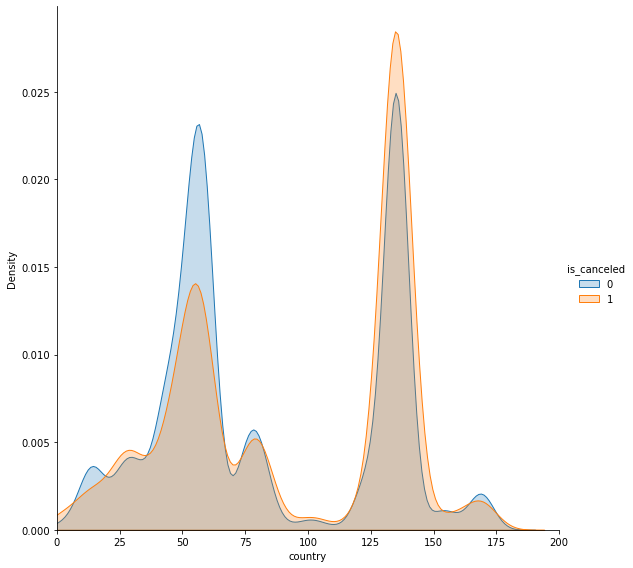

In [24]:
hotel_booking_temp = hotel_booking_cp.copy()
hotel_booking_temp['country'] = hotel_booking_cp['country'].cat.codes
sns.FacetGrid(data=hotel_booking_temp, hue = 'is_canceled',
             height = 8,
             xlim = (0,200)).map(sns.kdeplot, 'country', shade = True).add_legend()

In [25]:
hotel_booking_cp.groupby(['is_canceled', 'children'])['children'].count()

is_canceled  children
0            0.0         57842
             1.0          3230
             2.0          2090
             3.0            59
             10.0            0
1            0.0         21024
             1.0          1465
             2.0          1503
             3.0            16
             10.0            1
Name: children, dtype: int64

In [26]:
hotel_booking_cp.groupby(['is_canceled', 'required_car_parking_spaces'])['required_car_parking_spaces'].count()

is_canceled  required_car_parking_spaces
0            0                              55915
             1                               7273
             2                                 28
             3                                  3
             8                                  2
1            0                              24009
             1                                  0
             2                                  0
             3                                  0
             8                                  0
Name: required_car_parking_spaces, dtype: int64

**Nhận xét**: nếu người đặt yêu cầu nhiều chỗ trống để ô tô được đáp ứng thì khả năng họ sẽ không huỷ đặt chỗ.

In [27]:
hotel_booking_cp.groupby(['is_canceled', 'total_of_special_requests'])['required_car_parking_spaces'].count()

is_canceled  total_of_special_requests
0            0                            29228
             1                            22475
             2                             9280
             3                             1918
             4                              286
             5                               34
1            0                            14561
             1                             6501
             2                             2515
             3                              396
             4                               34
             5                                2
Name: required_car_parking_spaces, dtype: int64

In [28]:
a = hotel_booking_cp.groupby(['is_canceled', 'market_segment'], as_index=False)['lead_time'].mean()\
                    .sort_values(['is_canceled','lead_time'],ascending=False)
a

,is_canceled,market_segment,lead_time
12,1,Groups,182.242492
13,1,Offline TA/TO,134.867282
14,1,Online TA,102.882140
11,1,Direct,71.261946
10,1,Corporate,31.711198
9,1,Complementary,18.505882
8,1,Aviation,5.044444
15,1,Undefined,1.500000
4,0,Groups,135.179666
5,0,Offline TA/TO,101.162739


In [29]:
a = hotel_booking_cp.groupby(['is_canceled', 'market_segment'], as_index=False)['adr'].sum()\
                    .sort_values(['is_canceled','adr'],ascending=False)
a

,is_canceled,market_segment,adr
14,1,Online TA,2273368.05
11,1,Direct,220064.48
13,1,Offline TA/TO,189131.65
12,1,Groups,101682.23
10,1,Corporate,40527.00
8,1,Aviation,4524.50
9,1,Complementary,155.83
15,1,Undefined,30.00
6,0,Online TA,3825150.41
3,0,Direct,1155651.70


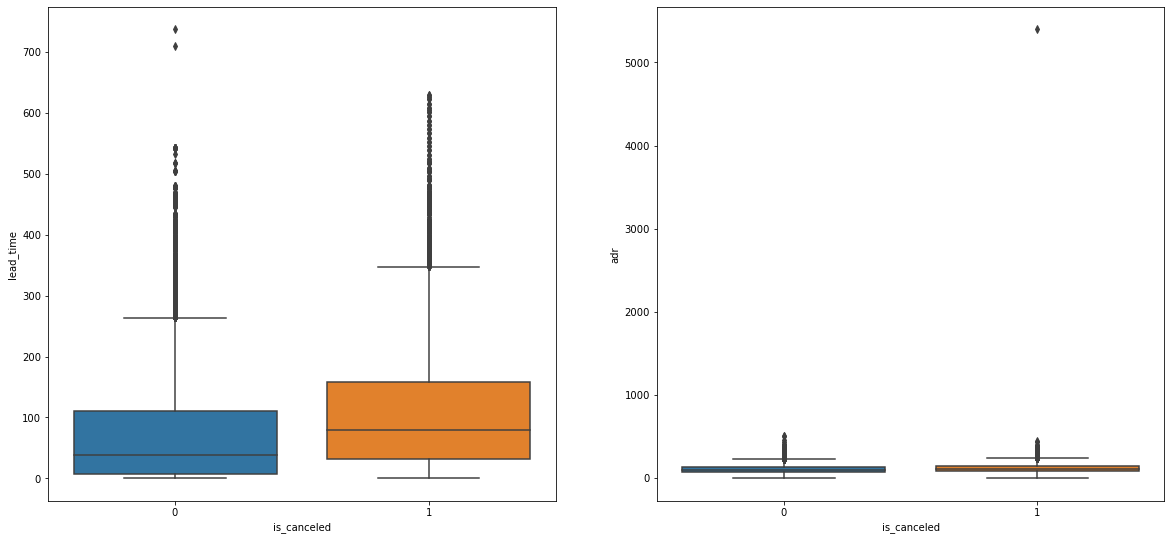

In [30]:
# Biểu đồ boxplot cho biết quan hệ giữa thuộc tính có kiểu numeric và thuộc tính 'hotel'
plt.figure(figsize=(20,20), facecolor='white')
plotnumber = 1
for feature in numerical_features:
    ax = plt.subplot(2,2,plotnumber)
    sns.boxplot(x='is_canceled', y= hotel_booking_cp[feature], data=hotel_booking)
    plt.xlabel('is_canceled')
    plotnumber += 1
plt.show()

**Nhận xét**: với khoảng thời gian chờ từ ngày đặt đến ngày 

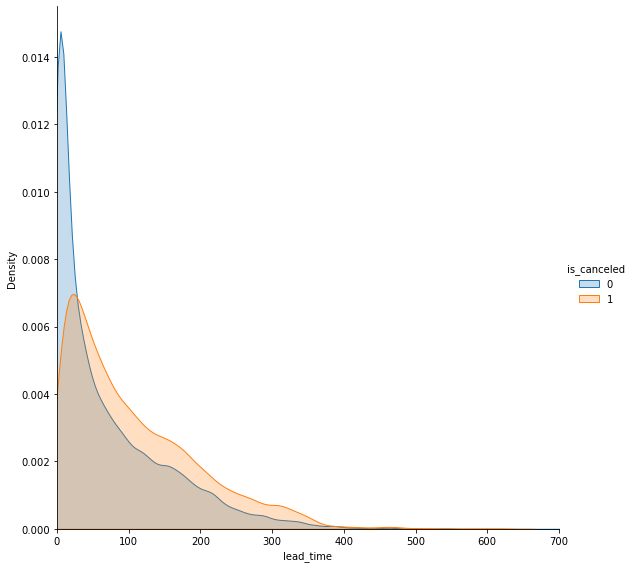

In [31]:
sns.FacetGrid(data=hotel_booking_cp, hue = 'is_canceled',
             height = 8,
             xlim = (0,700)).map(sns.kdeplot, 'lead_time', shade = True).add_legend()

**Nhận xét:** khoảng thời gian chờ càng lâu (trên 50 ngày) thì khả năng huỷ đặt phòng cao hơn.

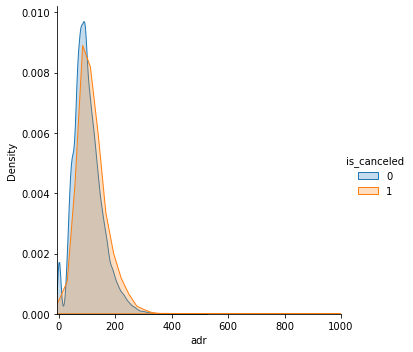

In [32]:
sns.FacetGrid(data=hotel_booking_cp, hue = 'is_canceled',
             height = 5,
             xlim = (hotel_booking['adr'].min(),1000))\
.map(sns.kdeplot, 'adr', shade = True)\
.add_legend()

In [33]:
correlation = hotel_booking.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.184515
required_car_parking_spaces       0.184456
adr                               0.127233
total_of_special_requests         0.120794
booking_changes                   0.093236
is_repeated_guest                 0.088764
arrival_date_year                 0.088020
stays_in_week_nights              0.084159
adults                            0.080271
children                          0.067182
stays_in_weekend_nights           0.060992
previous_bookings_not_canceled    0.052178
previous_cancellations            0.051501
babies                            0.020627
arrival_date_day_of_month         0.005449
days_in_waiting_list              0.004710
arrival_date_week_number          0.001691
Name: is_canceled, dtype: float64

## 4. Tiền xử lý dữ liệu

In [34]:
# phân loại lại các giá trị của biến *'country'*
# hotel_booking_cp['country'].value_counts().head(60)

In [35]:
# hotel_booking_cp['adults'] = hotel_booking_cp['adults'].astype('int64')
# hotel_booking_cp[hotel_booking_cp['adults'] > 4, 'adults'] = 4
#hotel_booking_cp['adults'].value_counts()

In [36]:
# hotel_booking_cp['booking_changes'].value_counts()

In [37]:
# hotel_booking.groupby(['is_canceled', 'stays_in_week_nights'])['stays_in_week_nights'].count().tail(60)

In [38]:
# hotel_booking.groupby(['is_canceled', 'stays_in_weekend_nights'])['stays_in_weekend_nights'].count()

In [39]:
# hotel_booking.loc[hotel_booking['stays_in_week_nights'].astype('int') >= 5] = 5

In [40]:
# hotel_booking.loc[hotel_booking['adults'] >= 4] = 4

### Xử lý dữ liệu outlier

In [41]:
hotel_booking_cp_2 = hotel_booking.copy()
# Xoá các quan sát có kết quả 'is_canceled' là 0 mà giá trị 'lead_time' trên 500
filtr = (hotel_booking_cp_2['is_canceled'] != 0) & (hotel_booking_cp_2['lead_time'] > 500)
hotel_booking_cp_2 = hotel_booking_cp_2[~filtr]

# 
hotel_booking_cp_2 = hotel_booking_cp_2[hotel_booking_cp_2['adr'] < 1000]
#
hotel_booking_cp_2 = hotel_booking_cp_2[hotel_booking_cp_2['children'] < 10]
#
hotel_booking_cp_2 = hotel_booking_cp_2[hotel_booking_cp_2['required_car_parking_spaces'] < 8]

print(f"input: {hotel_booking.shape}")
print(f"output: {hotel_booking_cp_2.shape}")

input: (87230, 30)
output: (87180, 30)


### Tách biến mục tiêu (dự đoán) ra khỏi tập dữ liệu

In [42]:
full_train_input = hotel_booking_cp_2.drop(columns='is_canceled')
full_train_output = hotel_booking_cp_2['is_canceled']

In [43]:
full_train_output.value_counts(normalize=True)

0    0.725155
1    0.274845
Name: is_canceled, dtype: float64

In [44]:
feature_selection = ['hotel', 'arrival_date_year', 'arrival_date_month', 'stays_in_weekend_nights'\
                     , 'stays_in_week_nights', 'adults', 'children', 'meal', 'country', 'arrival_date_week_number'\
                     , 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type'\
                     , 'booking_changes','customer_type', 'required_car_parking_spaces'\
                     , 'total_of_special_requests', 'lead_time', 'adr']

full_train_input = full_train_input[feature_selection]
full_train_input.shape

(87180, 20)

### Mã hoá các thuộc tính categorical

In [47]:
one_hot_features = ['hotel', 'arrival_date_year', 'arrival_date_month','children'\
                    , 'meal', 'market_segment','distribution_channel'\
                    , 'required_car_parking_spaces', 'total_of_special_requests']
full_train_input = pd.get_dummies(full_train_input, prefix=one_hot_features, columns=one_hot_features)
full_train_input.shape

(87180, 60)

In [48]:
full_train_input.head()

,stays_in_weekend_nights,stays_in_week_nights,adults,country,arrival_date_week_number,reserved_room_type,assigned_room_type,booking_changes,customer_type,lead_time,...,required_car_parking_spaces_0,required_car_parking_spaces_1,required_car_parking_spaces_2,required_car_parking_spaces_3,total_of_special_requests_0,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5
0,0,0,2,PRT,27,C,C,3,Transient,342,...,1,0,0,0,1,0,0,0,0,0
1,0,0,2,PRT,27,C,C,4,Transient,737,...,1,0,0,0,1,0,0,0,0,0
2,0,1,1,GBR,27,A,C,0,Transient,7,...,1,0,0,0,1,0,0,0,0,0
3,0,1,1,GBR,27,A,A,0,Transient,13,...,1,0,0,0,1,0,0,0,0,0
4,0,2,2,GBR,27,A,A,0,Transient,14,...,1,0,0,0,0,1,0,0,0,0


In [49]:
od_features = ['country', 'reserved_room_type', 'assigned_room_type', 'customer_type']
for col in od_features:
    full_train_input[col] = full_train_input[col].astype('category').cat.codes
full_train_input.head()

,stays_in_weekend_nights,stays_in_week_nights,adults,country,arrival_date_week_number,reserved_room_type,assigned_room_type,booking_changes,customer_type,lead_time,...,required_car_parking_spaces_0,required_car_parking_spaces_1,required_car_parking_spaces_2,required_car_parking_spaces_3,total_of_special_requests_0,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5
0,0,0,2,135,27,2,2,3,2,342,...,1,0,0,0,1,0,0,0,0,0
1,0,0,2,135,27,2,2,4,2,737,...,1,0,0,0,1,0,0,0,0,0
2,0,1,1,59,27,0,2,0,2,7,...,1,0,0,0,1,0,0,0,0,0
3,0,1,1,59,27,0,0,0,2,13,...,1,0,0,0,1,0,0,0,0,0
4,0,2,2,59,27,0,0,0,2,14,...,1,0,0,0,0,1,0,0,0,0


In [50]:
full_train_input.columns

Index(['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'country',
       'arrival_date_week_number', 'reserved_room_type', 'assigned_room_type',
       'booking_changes', 'customer_type', 'lead_time', 'adr',
       'hotel_City Hotel', 'hotel_Resort Hotel', 'arrival_date_year_2015',
       'arrival_date_year_2016', 'arrival_date_year_2017',
       'arrival_date_month_April', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September',
       'children_0.0', 'children_1.0', 'children_2.0', 'children_3.0',
       'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segm

### Chia tập train và tập validation

In [51]:
train_input, val_input, train_output, val_output = train_test_split(
    full_train_input,
    full_train_output,
    test_size=0.3,
    stratify=full_train_output,
    random_state=0
)

In [52]:
train_input.shape

(61026, 60)

In [ ]:
train_output.shape

In [ ]:
val_input.shape

In [ ]:
val_output.shape

## 5. Xây dựng mô hình dự đoán

In [53]:
# Khởi tạo và huấn luyện mô hình
LogR_model = LogisticRegression()
LogR_model.fit(train_input, train_output)
# Dự đoán 
y_pred_LogR = LogR_model.predict(val_input)
# Xác định độ chính xác của mô hình
accuracy_LogG = accuracy_score(val_output, y_pred_LogR) 
print("Accuracy: %.2f%%" % (accuracy_LogG * 100.0))

Accuracy: 76.68%


In [54]:
# Khởi tạo và huấn luyện mô hình
DecTree_model = DecisionTreeClassifier()
DecTree_model.fit(train_input, train_output)

DecisionTreeClassifier()

In [56]:
std_slc = StandardScaler()

#pca = decomposition.PCA()

dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])
# n_components = list(range(1,train_input.shape[1]+1,1))

criterion = ['gini', 'entropy']
max_depth = range(1, 13)

parameters = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(train_input, train_output)
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])
print(clf_GS.best_score_)

Best Criterion: gini
Best max_depth: 10

DecisionTreeClassifier(max_depth=10)
0.8096057485915515


In [57]:
# Xây dựng mô hình với thuật toán Random Forest Classifier
rd_clf = RandomForestClassifier()
rd_clf.fit(train_input, train_output)

y_pred_rd_clf = rd_clf.predict(val_input)

acc_rd_clf = accuracy_score(val_output, y_pred_rd_clf)
conf = confusion_matrix(val_output, y_pred_rd_clf)
clf_report = classification_report(val_output, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.8303892330045117
Confusion Matrix : 
[[17398  1568]
 [ 2868  4320]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     18966
           1       0.73      0.60      0.66      7188

    accuracy                           0.83     26154
   macro avg       0.80      0.76      0.77     26154
weighted avg       0.82      0.83      0.82     26154



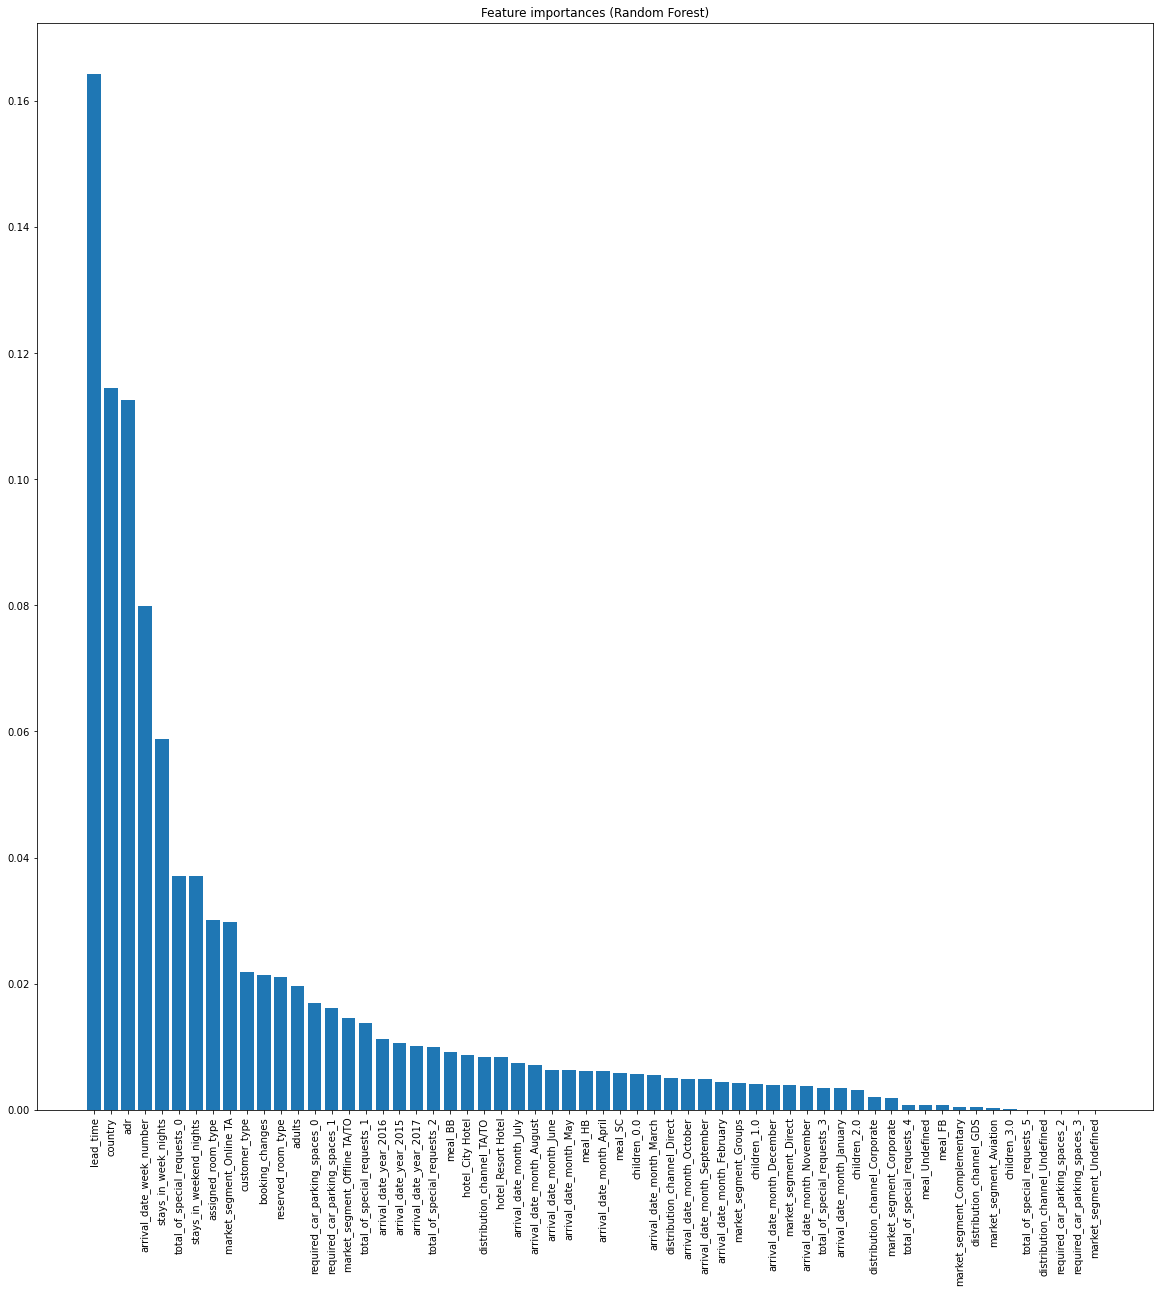

In [58]:
#Lấy ra các thuộc tính quan trọng từ model 
headers = ["name", "score"]
values = sorted(zip(train_input.columns, rd_clf.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)

fig = plt.figure(figsize=(20,20))
x_pos = np.arange(0, len(feature_importances))
plt.bar(x_pos, feature_importances['score'], align='center')
plt.xticks(rotation=90)
plt.xticks(x_pos, feature_importances['name'])
plt.title('Feature importances (Random Forest)')

plt.show()

In [59]:
feature_importances[feature_importances['score'] > 0.01]

,name,score
0,lead_time,0.164161
1,country,0.114470
2,adr,0.112475
3,arrival_date_week_number,0.079841
4,stays_in_week_nights,0.058812
5,total_of_special_requests_0,0.037161
6,stays_in_weekend_nights,0.037103
7,assigned_room_type,0.030174
8,market_segment_Online TA,0.029850
9,customer_type,0.021892
